In [149]:
%matplotlib inline
import glob
import os
import librosa
import numpy as np

import matplotlib.pyplot as plt
import tensorflow as tf


In [150]:
# https://www.youtube.com/watch?v=MhOdbtPhbLU
# see if I can get one of these for conv layers
def extract_feature(file_name):
    X, sample_rate = librosa.load(file_name)
    # spectogram with shape 60 and 100
    melspec = librosa.feature.melspectrogram(X, n_mels = 60, sr=sample_rate)
    logspec = librosa.logamplitude(melspec)
    y_shape = logspec.shape[1]
    if y_shape < 101:
        diff= 101-y_shape
        mod = diff%2
        if mod==0:
            pad = int(diff/2)
            logspec = np.pad(logspec, [(0, 0), (pad, pad)], mode='constant')
        else:
            pad_left = int(np.floor(diff/2))
            pad_right = pad_left + 1
            logspec = np.pad(logspec, [(0, 0), (pad_left, pad_right)], mode='constant')
        
    return logspec[:,:100].reshape(1,60,100,1)

def parse_audio_files(parent_dir,sub_dirs,file_ext="*.wav"):
    features, labels = None, np.empty(0)
    for label, sub_dir in enumerate(sub_dirs):
        for fn in glob.glob(os.path.join(parent_dir, sub_dir, file_ext)):
            try:
                logspec = extract_feature(fn)
            except Exception as e:
                print( "Error encountered while parsing file: ", fn, str(e))
                continue
            if features ==None:
                features = logspec
            else:
                features = np.concatenate((features,logspec), axis=0)
            labels = np.append(labels, fn.split('/')[2].split('-')[1])
    return np.array(features), np.array(labels, dtype = np.int)

def one_hot_encode(labels):
    n_labels = len(labels)
    n_unique_labels = len(np.unique(labels))
    one_hot_encode = np.zeros((n_labels,n_unique_labels))
    one_hot_encode[np.arange(n_labels), labels] = 1
    return one_hot_encode

In [151]:
parent_dir = 'data'
tr_sub_dirs = ["fold8","fold9"]
# ts_sub_dirs = ["fold1"]
tr_features_get, tr_labels_get = parse_audio_files(parent_dir,tr_sub_dirs)
# ts_features, ts_labels = parse_audio_files(parent_dir,ts_sub_dirs)

tr_labels_get = one_hot_encode(tr_labels_get)


/home/ubuntu/.conda/envs/sounds/lib/python3.6/site-packages/ipykernel_launcher.py:31: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/home/ubuntu/.conda/envs/sounds/lib/python3.6/site-packages/ipykernel_launcher.py:31: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/home/ubuntu/.conda/envs/sounds/lib/python3.6/site-packages/ipykernel_launcher.py:31: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/home/ubuntu/.conda/envs/sounds/lib/python3.6/site-packages/ipykernel_launcher.py:31: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/home/ubuntu/.conda/envs/sounds/lib/python3.6/site-packages/ipykernel_launcher.py:31: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/home/ubuntu/.conda/envs/sounds/lib/python3.6/site-packages/ipykernel_launc

/home/ubuntu/.conda/envs/sounds/lib/python3.6/site-packages/ipykernel_launcher.py:31: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/home/ubuntu/.conda/envs/sounds/lib/python3.6/site-packages/ipykernel_launcher.py:31: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/home/ubuntu/.conda/envs/sounds/lib/python3.6/site-packages/ipykernel_launcher.py:31: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/home/ubuntu/.conda/envs/sounds/lib/python3.6/site-packages/ipykernel_launcher.py:31: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/home/ubuntu/.conda/envs/sounds/lib/python3.6/site-packages/ipykernel_launcher.py:31: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/home/ubuntu/.conda/envs/sounds/lib/python3.6/site-packages/ipykernel_launc

/home/ubuntu/.conda/envs/sounds/lib/python3.6/site-packages/ipykernel_launcher.py:31: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/home/ubuntu/.conda/envs/sounds/lib/python3.6/site-packages/ipykernel_launcher.py:31: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/home/ubuntu/.conda/envs/sounds/lib/python3.6/site-packages/ipykernel_launcher.py:31: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/home/ubuntu/.conda/envs/sounds/lib/python3.6/site-packages/ipykernel_launcher.py:31: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/home/ubuntu/.conda/envs/sounds/lib/python3.6/site-packages/ipykernel_launcher.py:31: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/home/ubuntu/.conda/envs/sounds/lib/python3.6/site-packages/ipykernel_launc

/home/ubuntu/.conda/envs/sounds/lib/python3.6/site-packages/ipykernel_launcher.py:31: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/home/ubuntu/.conda/envs/sounds/lib/python3.6/site-packages/ipykernel_launcher.py:31: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/home/ubuntu/.conda/envs/sounds/lib/python3.6/site-packages/ipykernel_launcher.py:31: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/home/ubuntu/.conda/envs/sounds/lib/python3.6/site-packages/ipykernel_launcher.py:31: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/home/ubuntu/.conda/envs/sounds/lib/python3.6/site-packages/ipykernel_launcher.py:31: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/home/ubuntu/.conda/envs/sounds/lib/python3.6/site-packages/ipykernel_launc

/home/ubuntu/.conda/envs/sounds/lib/python3.6/site-packages/ipykernel_launcher.py:31: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/home/ubuntu/.conda/envs/sounds/lib/python3.6/site-packages/ipykernel_launcher.py:31: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/home/ubuntu/.conda/envs/sounds/lib/python3.6/site-packages/ipykernel_launcher.py:31: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/home/ubuntu/.conda/envs/sounds/lib/python3.6/site-packages/ipykernel_launcher.py:31: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/home/ubuntu/.conda/envs/sounds/lib/python3.6/site-packages/ipykernel_launcher.py:31: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/home/ubuntu/.conda/envs/sounds/lib/python3.6/site-packages/ipykernel_launc

/home/ubuntu/.conda/envs/sounds/lib/python3.6/site-packages/ipykernel_launcher.py:31: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/home/ubuntu/.conda/envs/sounds/lib/python3.6/site-packages/ipykernel_launcher.py:31: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/home/ubuntu/.conda/envs/sounds/lib/python3.6/site-packages/ipykernel_launcher.py:31: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/home/ubuntu/.conda/envs/sounds/lib/python3.6/site-packages/ipykernel_launcher.py:31: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/home/ubuntu/.conda/envs/sounds/lib/python3.6/site-packages/ipykernel_launcher.py:31: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/home/ubuntu/.conda/envs/sounds/lib/python3.6/site-packages/ipykernel_launc

/home/ubuntu/.conda/envs/sounds/lib/python3.6/site-packages/ipykernel_launcher.py:31: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/home/ubuntu/.conda/envs/sounds/lib/python3.6/site-packages/ipykernel_launcher.py:31: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/home/ubuntu/.conda/envs/sounds/lib/python3.6/site-packages/ipykernel_launcher.py:31: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/home/ubuntu/.conda/envs/sounds/lib/python3.6/site-packages/ipykernel_launcher.py:31: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/home/ubuntu/.conda/envs/sounds/lib/python3.6/site-packages/ipykernel_launcher.py:31: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/home/ubuntu/.conda/envs/sounds/lib/python3.6/site-packages/ipykernel_launc

/home/ubuntu/.conda/envs/sounds/lib/python3.6/site-packages/ipykernel_launcher.py:31: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/home/ubuntu/.conda/envs/sounds/lib/python3.6/site-packages/ipykernel_launcher.py:31: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/home/ubuntu/.conda/envs/sounds/lib/python3.6/site-packages/ipykernel_launcher.py:31: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/home/ubuntu/.conda/envs/sounds/lib/python3.6/site-packages/ipykernel_launcher.py:31: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/home/ubuntu/.conda/envs/sounds/lib/python3.6/site-packages/ipykernel_launcher.py:31: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/home/ubuntu/.conda/envs/sounds/lib/python3.6/site-packages/ipykernel_launc

/home/ubuntu/.conda/envs/sounds/lib/python3.6/site-packages/ipykernel_launcher.py:31: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/home/ubuntu/.conda/envs/sounds/lib/python3.6/site-packages/ipykernel_launcher.py:31: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/home/ubuntu/.conda/envs/sounds/lib/python3.6/site-packages/ipykernel_launcher.py:31: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/home/ubuntu/.conda/envs/sounds/lib/python3.6/site-packages/ipykernel_launcher.py:31: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/home/ubuntu/.conda/envs/sounds/lib/python3.6/site-packages/ipykernel_launcher.py:31: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/home/ubuntu/.conda/envs/sounds/lib/python3.6/site-packages/ipykernel_launc

/home/ubuntu/.conda/envs/sounds/lib/python3.6/site-packages/ipykernel_launcher.py:31: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/home/ubuntu/.conda/envs/sounds/lib/python3.6/site-packages/ipykernel_launcher.py:31: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/home/ubuntu/.conda/envs/sounds/lib/python3.6/site-packages/ipykernel_launcher.py:31: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/home/ubuntu/.conda/envs/sounds/lib/python3.6/site-packages/ipykernel_launcher.py:31: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/home/ubuntu/.conda/envs/sounds/lib/python3.6/site-packages/ipykernel_launcher.py:31: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/home/ubuntu/.conda/envs/sounds/lib/python3.6/site-packages/ipykernel_launc

/home/ubuntu/.conda/envs/sounds/lib/python3.6/site-packages/ipykernel_launcher.py:31: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/home/ubuntu/.conda/envs/sounds/lib/python3.6/site-packages/ipykernel_launcher.py:31: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/home/ubuntu/.conda/envs/sounds/lib/python3.6/site-packages/ipykernel_launcher.py:31: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/home/ubuntu/.conda/envs/sounds/lib/python3.6/site-packages/ipykernel_launcher.py:31: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/home/ubuntu/.conda/envs/sounds/lib/python3.6/site-packages/ipykernel_launcher.py:31: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/home/ubuntu/.conda/envs/sounds/lib/python3.6/site-packages/ipykernel_launc

In [152]:
tr_features = np.load('cnn_tr_features.npy')
tr_labels = np.load('cnn_tr_labels.npy')

tr_features = np.append(tr_features, tr_features_get, axis=0)
tr_labels = np.append(tr_labels, tr_labels_get, axis=0)


In [153]:

np.save('cnn_tr_features.npy', tr_features, allow_pickle=True)
np.save('cnn_tr_labels.npy', tr_labels, allow_pickle=True)

children playing


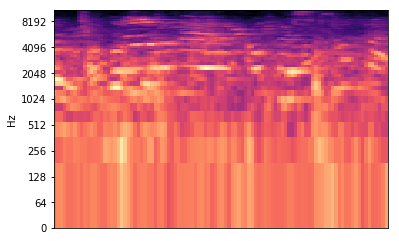

In [154]:
import librosa.display
sound_names = ["air conditioner","car horn","children playing",
"dog bark","drilling","engine idling", "gun shot",
"jackhammer","siren","street music"]
print(sound_names[np.argmax(tr_labels[20])])
librosa.display.specshow(tr_features[20].reshape(60,100), y_axis='log')

drilling


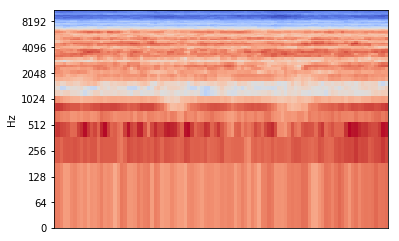

In [155]:
sound_names = ["air conditioner","car horn","children playing",
"dog bark","drilling","engine idling", "gun shot",
"jackhammer","siren","street music"]
print(sound_names[np.argmax(tr_labels[500])])
librosa.display.specshow(tr_features[500].reshape(60,100), y_axis='log')

In [156]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential()
model.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu', 
                        input_shape=(60, 100, 1)))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(500, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(10, activation='softmax'))

model.summary()



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 60, 100, 16)       80        
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 30, 50, 16)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 30, 50, 32)        2080      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 15, 25, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 15, 25, 64)        8256      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 7, 12, 64)         0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 7, 12, 64)         0         
__________

In [159]:
# compile the model
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', 
                  metrics=['accuracy'])

tr_features.shape

(2904, 60, 100, 1)

In [160]:


from keras.callbacks import ModelCheckpoint   
x_train, y_train = tr_features[:2000],tr_labels[:2000]
x_valid, y_valid = tr_features[2000:2500],tr_labels[2000:2500]
x_test, y_test = tr_features[2500:],tr_labels[2500:]
# train the model
checkpointer = ModelCheckpoint(filepath='model.weights.best_cnn.hdf5', verbose=1, 
                               save_best_only=True)
hist = model.fit(x_train, y_train, batch_size=32, epochs=100,
          validation_data=(x_valid, y_valid), callbacks=[checkpointer], 
          verbose=2, shuffle=True)



Train on 2000 samples, validate on 500 samples
Epoch 1/100
Epoch 00000: val_loss improved from inf to 1.54047, saving model to model.weights.best_cnn.hdf5
8s - loss: 1.3244 - acc: 0.6210 - val_loss: 1.5405 - val_acc: 0.5200
Epoch 2/100
Epoch 00001: val_loss did not improve
7s - loss: 0.7864 - acc: 0.7525 - val_loss: 1.5452 - val_acc: 0.5680
Epoch 3/100
Epoch 00002: val_loss improved from 1.54047 to 1.44384, saving model to model.weights.best_cnn.hdf5
7s - loss: 0.6002 - acc: 0.8095 - val_loss: 1.4438 - val_acc: 0.6520
Epoch 4/100
Epoch 00003: val_loss did not improve
7s - loss: 0.5126 - acc: 0.8475 - val_loss: 1.6641 - val_acc: 0.5900
Epoch 5/100
Epoch 00004: val_loss did not improve
7s - loss: 0.3911 - acc: 0.8690 - val_loss: 1.4468 - val_acc: 0.6400
Epoch 6/100
Epoch 00005: val_loss did not improve
7s - loss: 0.3646 - acc: 0.8770 - val_loss: 1.5088 - val_acc: 0.6740
Epoch 7/100
Epoch 00006: val_loss did not improve
7s - loss: 0.3076 - acc: 0.9040 - val_loss: 1.4468 - val_acc: 0.6640


Epoch 00067: val_loss did not improve
7s - loss: 0.0285 - acc: 0.9920 - val_loss: 1.8812 - val_acc: 0.7860
Epoch 69/100
Epoch 00068: val_loss did not improve
7s - loss: 0.0243 - acc: 0.9930 - val_loss: 2.2781 - val_acc: 0.7600
Epoch 70/100
Epoch 00069: val_loss did not improve
7s - loss: 0.0114 - acc: 0.9950 - val_loss: 2.1610 - val_acc: 0.7620
Epoch 71/100
Epoch 00070: val_loss did not improve
7s - loss: 0.0624 - acc: 0.9865 - val_loss: 2.7123 - val_acc: 0.7320
Epoch 72/100
Epoch 00071: val_loss did not improve
7s - loss: 0.0685 - acc: 0.9880 - val_loss: 2.3780 - val_acc: 0.7780
Epoch 73/100
Epoch 00072: val_loss did not improve
7s - loss: 0.0400 - acc: 0.9885 - val_loss: 2.3542 - val_acc: 0.7380
Epoch 74/100
Epoch 00073: val_loss did not improve
7s - loss: 0.0317 - acc: 0.9905 - val_loss: 2.4327 - val_acc: 0.7500
Epoch 75/100
Epoch 00074: val_loss did not improve
7s - loss: 0.0342 - acc: 0.9900 - val_loss: 2.4859 - val_acc: 0.7500
Epoch 76/100
Epoch 00075: val_loss did not improve
7s

In [161]:
# evaluate and print test accuracy
score = model.evaluate(x_test, y_test, verbose=0)
print('\n', 'Test accuracy:', score[1])


 Test accuracy: 0.643564357616


In [162]:
parent_dir = 'data'
tr_sub_dirs = ["my_data"]
# ts_sub_dirs = ["fold1"]
tr_features_get, tr_labels_get = parse_audio_files(parent_dir,tr_sub_dirs)
# ts_features, ts_labels = parse_audio_files(parent_dir,ts_sub_dirs)

# tr_labels_get = one_hot_encode(tr_labels_get)
tf_labels = np.array([[1,0,0,0,0,0,0,0,0,0],[0,0,0,1,0,0,0,0,0,0],[0,1,0,0,0,0,0,0,0,0],[1,0,0,0,0,0,0,0,0,0],[0,0,0,1,0,0,0,0,0,0],[0,0,0,1,0,0,0,0,0,0]])


/home/ubuntu/.conda/envs/sounds/lib/python3.6/site-packages/ipykernel_launcher.py:31: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


In [163]:
# evaluate and print test accuracy
score = model.evaluate(tr_features_get, tf_labels, verbose=0)
print('\n', 'Test accuracy:', score[1])
np.argmax(model.predict(tr_features_get),axis=1)


 Test accuracy: 0.666666686535


array([2, 3, 1, 3, 3, 3])